# Activity 3: Exploring Bitcoin Dataset
We explore the Bitcoin dataset in this Jupyter Notebook. First, we start by importing the required libraries. 

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Magic Commands
Magic commands (those that start with `%`) are commands that modify a configuration of Jupyter Notebooks. A number of magic commands are available by default (see list [here](http://ipython.readthedocs.io/en/stable/interactive/magics.html))--and many more can be added with extensions. The magic command added in this section allows `matplotlib` to display our plots directly on the browser instead of having to save them on a local file.

In [19]:
%matplotlib inline

### Introduction

We will also import our custom set of normalization functions. 

In [20]:
import normalizations

Let's load the dataset as a pandas `DataFrame`. This will make it easy to compute basic properties from the dataset and to clean any irregularities. 

In [21]:
bitcoin = pd.read_csv('data/bitcoin_dataset.csv', date_parser=['date'])

In [22]:
bitcoin.head()

,date,open,high,low,close,volume,iso_week
0,2014-09-27,403.556000,406.622986,397.372009,399.519989,15029300,2014-39
1,2014-09-28,399.471008,401.016998,374.332001,377.181000,23613300,2014-39
2,2014-09-29,376.928009,385.210999,372.239990,375.467010,32497700,2014-40
3,2014-09-30,376.088013,390.976990,373.442993,386.944000,34707300,2014-40
4,2014-10-01,387.427002,391.378998,380.779999,383.614990,26229400,2014-40


Our dataset contains 7 variables (i.e. columns). Here's what each one of them represents:

* `date`: date of the observation.
* `open`: open value of a single Bitcoin coin.
* `high`: highest value achieved during a given day period.
* `low`: lowest value achieved during a given day period.
* `close`: value at the close of the transaction day.
* `volume`: what is the total volume of Bitcoin that was exchanged during that day.
* `iso_week`: week number of a given year.

All values are in USD.

### Exploration
We will now explore the dataset timeseries to understand its patterns. 

Let's first explore two variables: close price and volume.

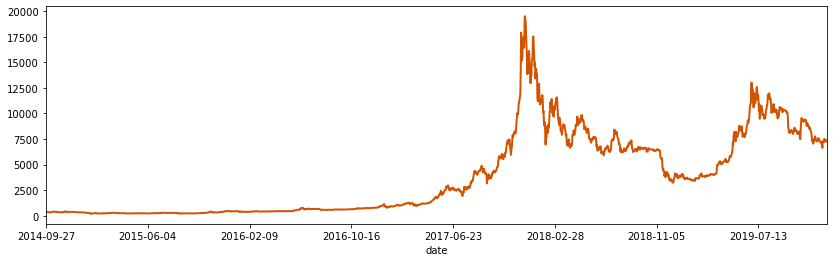

In [23]:
bitcoin.set_index('date')['close'].plot(linewidth=2, figsize=(14, 4), color='#d35400')

#plt.plot(bitcoin['date'], bitcoin['close'])

In [24]:
#
#  Make a similar plot for the volume variable here.
#  How different is the volume data compared to 
#  the closing prices every day?
#

Now let's explore the range from 2017 to 2018. These are the years where the prices of bitcoin were high initially and then started declining and then gained back again!

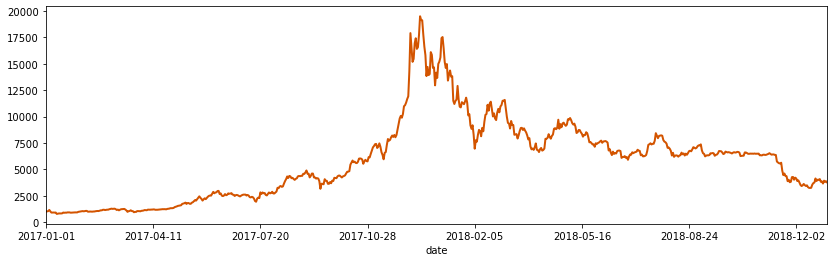

In [25]:
bitcoin[(bitcoin['date'] >= '2017-01-01') & (bitcoin['date'] <= '2018-12-31') ].set_index('date')['close'].plot(
    linewidth=2, figsize=(14, 4), color='#d35400')

In [26]:
#
#  Again, make a similar plot for the volume variable.
#

### Preparing Dataset for Model
Neural networks typically work with either [matrices](https://en.wikipedia.org/wiki/Matrix_(mathematics)) or [tensors](https://en.wikipedia.org/wiki/Tensor). Our data needs to fit that structure before it can be used by either `keras` (or `tensorflow`). 

Also, it is common practice to normalize data before using it to train a neural network. We will be using a normalization technique the evaluates each observation into a range between 0 and 1 in relation to the first observation in each week.

In [27]:
bitcoin.head()

,date,open,high,low,close,volume,iso_week
0,2014-09-27,403.556000,406.622986,397.372009,399.519989,15029300,2014-39
1,2014-09-28,399.471008,401.016998,374.332001,377.181000,23613300,2014-39
2,2014-09-29,376.928009,385.210999,372.239990,375.467010,32497700,2014-40
3,2014-09-30,376.088013,390.976990,373.442993,386.944000,34707300,2014-40
4,2014-10-01,387.427002,391.378998,380.779999,383.614990,26229400,2014-40


First, let's remove data from older periods. We will keep only data from 2016 until the latest observation of 2020. Older observations may be useful to understand current prices. However, Bitcoin has gained so much popularity in recent years that including older data would require a more laborious treatment. We will leave that for a future exploration.

In [28]:
bitcoin_recent = bitcoin[bitcoin['date'] >= '2016-01-04']

Let's keep only the close and volume variables. We can use the other variables in another time.

In [29]:
bitcoin_recent = bitcoin_recent[['date', 'iso_week', 'close', 'volume']]

Now, let's normalize our data for both the `close` and `volume` variables.

In [30]:
bitcoin_recent['close_point_relative_normalization'] = bitcoin_recent.groupby('iso_week')['close'].apply(
    lambda x: normalizations.point_relative_normalization(x))

In [31]:
#
#  Now, apply the same normalization on the volume variable.
#  Name that variable using the same convention
#  from the previous example. Use the name:
#   
#     `volume_point_relative_normalization`
#

After the normalization procedure, our variables `close` and `volume` are now relative to the first observation of every week. We will be using these variables -- `close_point_relative_normalization` and `volume_point_relative_normalization`, respectivelly -- to train our LSTM model.

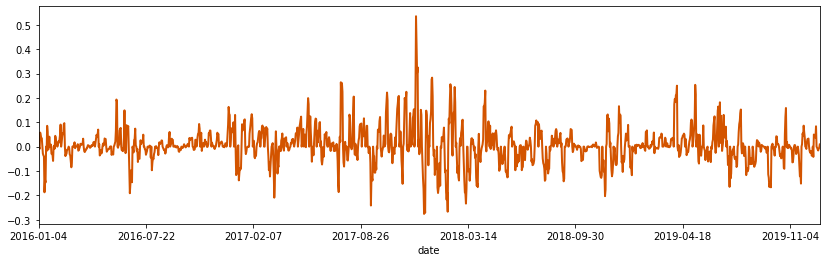

In [32]:
bitcoin_recent.set_index('date')['close_point_relative_normalization'].plot(
    linewidth=2, figsize=(14, 4), color='#d35400')

In [33]:
#
#  Now, plot he volume variable (`volume_point_relative_normalization`)
#  in the same way as the plot above. 
#

### Training and Test Sets
Let's divide the dataset into a training and a test set. In this case, we will use 80% of the dataset to train our LSTM model and 20% to evaluate its performance.

Given that the data is continuous, we use the last 20% of available weeks as a test set and the first 80% as a training set.

In [34]:
boundary = int(0.9 * bitcoin_recent['iso_week'].nunique())
train_set_weeks = bitcoin_recent['iso_week'].unique()[0:boundary]
test_set_weeks = bitcoin_recent[~bitcoin_recent['iso_week'].isin(train_set_weeks)]['iso_week'].unique()

In [35]:
train_set_weeks

array(['2016-1', '2016-2', '2016-3', '2016-4', '2016-5', '2016-6',
       '2016-7', '2016-8', '2016-9', '2016-10', '2016-11', '2016-12',
       '2016-13', '2016-14', '2016-15', '2016-16', '2016-17', '2016-18',
       '2016-19', '2016-20', '2016-21', '2016-22', '2016-23', '2016-24',
       '2016-25', '2016-26', '2016-27', '2016-28', '2016-29', '2016-30',
       '2016-31', '2016-32', '2016-33', '2016-34', '2016-35', '2016-36',
       '2016-37', '2016-38', '2016-39', '2016-40', '2016-41', '2016-42',
       '2016-43', '2016-44', '2016-45', '2016-46', '2016-47', '2016-48',
       '2016-49', '2016-50', '2016-51', '2016-52', '2017-1', '2017-2',
       '2017-3', '2017-4', '2017-5', '2017-6', '2017-7', '2017-8',
       '2017-9', '2017-10', '2017-11', '2017-12', '2017-13', '2017-14',
       '2017-15', '2017-16', '2017-17', '2017-18', '2017-19', '2017-20',
       '2017-21', '2017-22', '2017-23', '2017-24', '2017-25', '2017-26',
       '2017-27', '2017-28', '2017-29', '2017-30', '2017-31', '2017-3

In [36]:
test_set_weeks

array(['2019-32', '2019-33', '2019-34', '2019-35', '2019-36', '2019-37',
       '2019-38', '2019-39', '2019-40', '2019-41', '2019-42', '2019-43',
       '2019-44', '2019-45', '2019-46', '2019-47', '2019-48', '2019-49',
       '2019-50', '2019-51', '2019-52'], dtype=object)

Now, let's create the separate datasets for each operation.

In [37]:
train_dataset = bitcoin_recent[bitcoin_recent['iso_week'].isin(train_set_weeks)]


In [38]:
#
#  Perform the same operation as above, but use the
#  `test_set_weeks` list to create the variable `test_dataset`.
#

### Storing Output
Before closing this notebook, let's store the output of this exercise on disk to make sure it is easier to use this data as input to our neural network. 

In [39]:
bitcoin_recent.to_csv('data/bitcoin_recent.csv', index=False)
train_dataset.to_csv('data/train_dataset.csv', index=False)


In [40]:
#
#  Perform the same operation as above to save the test file to disk as well
#

### Summary
In this section, we explored the Bitcoin dataset. We learned that during year of 2017 the prices of Bitcoin skyrocketed and afterwards it started falling. It recovered back in 2018 to some extent but it is yet to reach what it reached in 2017. This phenomenon takes a long time to take place—and may be influenced by a number of external factors that this data alone doesn't explain (for instance, the emergence of other cryptocurrencies, the ban of cryptocurrencies in some markets).

Can we predict the price of Bitcoin in the future? What will it be 30 days from now? We will be building a deep learning model to explore that question in our next section.